This Notebook on the behalf of code task of fellowship.ai 

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stanford-car-dataset-by-classes-folder']


Import libraries

In [6]:
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

# Prepare Data

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_dir = "../input/stanford-cars-dataset"

train_transform = transforms.Compose([
                                transforms.Resize(150),
                                transforms.RandomResizedCrop(150),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(150),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_data  = datasets.ImageFolder('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/', train_transform)
test_data = datasets.ImageFolder('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/', test_transform)

Load Class and ids

In [8]:
classes = train_data.classes
class_idx = train_data.class_to_idx
class_idx
len(class_idx)

196

Prepare Data loader

In [9]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=1)

print(len(train_loader))

82


Check shape of Image

In [10]:
images , labels = next(iter(train_loader))
images.shape, len(labels)

(torch.Size([100, 3, 150, 150]), 100)

# Visualize 
data from data loder

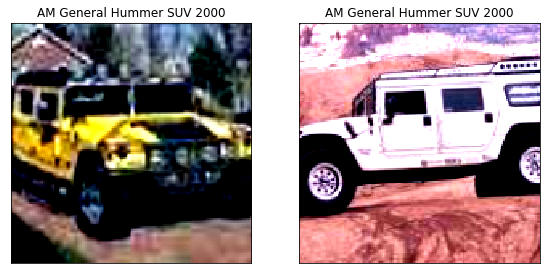

In [11]:
# visualize data
import numpy as np
import matplotlib.pyplot as plt

data_iter = iter(test_loader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormolaize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])

# **First Try with Just freazing the network and just training the classifier**

## Load ResNet50 model

In [12]:
model = models.resnet50(pretrained=True)
model.fc

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 25736144.19it/s]


Linear(in_features=2048, out_features=1000, bias=True)

Freeze Parameters

In [13]:
for param in model.parameters():
    param.required_grad = False

### Change the last linear Layer

In [14]:
import torch.nn as nn
from collections import OrderedDict

classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1024, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=512, out_features=196),
  nn.LogSoftmax(dim=1)  
)
    
model.fc = classifier
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.3)
  (6): Linear(in_features=512, out_features=196, bias=True)
  (7): LogSoftmax()
)

In [15]:
import torch.optim as optim
import torch

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Training

In [15]:
n_epochs = 5

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        n_epochs,
        train_loss,
        valid_loss
        ))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1/5 	Training Loss: 0.052858 	Validation Loss: 0.049753
		Validation loss decreased (inf --> 0.049753).  Saving model ...
Epoch: 2/5 	Training Loss: 0.049895 	Validation Loss: 0.047204
		Validation loss decreased (0.049753 --> 0.047204).  Saving model ...
Epoch: 3/5 	Training Loss: 0.048247 	Validation Loss: 0.045105
		Validation loss decreased (0.047204 --> 0.045105).  Saving model ...
Epoch: 4/5 	Training Loss: 0.047456 	Validation Loss: 0.044399
		Validation loss decreased (0.045105 --> 0.044399).  Saving model ...
Epoch: 5/5 	Training Loss: 0.046037 	Validation Loss: 0.042860
		Validation loss decreased (0.044399 --> 0.042860).  Saving model ...


# **Second training but with more few trainable wieghts of the Resnet50**

In [16]:
model2 = models.resnet50(pretrained=True)

classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1024, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=512, out_features=196),
  nn.LogSoftmax(dim=1)  
)
    
model2.fc = classifier

cont = 0
for param in model2.parameters():
    param.required_grad = False
    if cont > 65:
        break
        
import torch.optim as optim
import torch

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [17]:
n_epochs = 5

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model2.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model2.eval() # prep model for evaluation
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        n_epochs,
        train_loss,
        valid_loss
        ))
#     print('\t\tTest Accuracy: %4d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1/5 	Training Loss: 0.053169 	Validation Loss: 0.053210
		Validation loss decreased (inf --> 0.053210).  Saving model ...
Epoch: 2/5 	Training Loss: 0.053179 	Validation Loss: 0.053211
Epoch: 3/5 	Training Loss: 0.053169 	Validation Loss: 0.053211
Epoch: 4/5 	Training Loss: 0.053184 	Validation Loss: 0.053211
Epoch: 5/5 	Training Loss: 0.053178 	Validation Loss: 0.053211


# **3rd Try with less late parameters in the network**

## Load Saved best model

In [18]:
model3 = models.resnet50(pretrained=True)

classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1024, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=512, out_features=196),
  nn.LogSoftmax(dim=1)  
)
    
model3.fc = classifier

cont = 0
for param in model3.parameters():
    param.required_grad = False
    if cont > 100:
        break

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

#gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

n_epochs = 5

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model3.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model3(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model3.eval() # prep model for evaluation
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model3(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        n_epochs,
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1/5 	Training Loss: 0.053183 	Validation Loss: 0.053182
		Validation loss decreased (inf --> 0.053182).  Saving model ...
Epoch: 2/5 	Training Loss: 0.053180 	Validation Loss: 0.053183
Epoch: 3/5 	Training Loss: 0.053187 	Validation Loss: 0.053183
Epoch: 4/5 	Training Loss: 0.053182 	Validation Loss: 0.053183
Epoch: 5/5 	Training Loss: 0.053189 	Validation Loss: 0.053183


**This low number of epocs may affect the loss but the art behind the transfer learning is that you can use the weights of the model which was trained for some classification for features or embedding generation.**

**The art of this you may got alot easier high level accuracy and less work on the model and more work on the data cleaning and augmentation to get more accuracy without over fitting your classifier**

**You may freeze the early layers and train more in the late layers so you can get more cusomized features in the late layers and that’s because in  the late layers it’s more sophisticated features and that was explained  very well in my course with andrew on Coursera which gave me a great intuition about the transfer learning and how powerful is the transfer learning is.**

**Ofcourse the classifier only training would give higher accuracy with such low number of epocs and may get better with more epocs for sure.**

**Freezing less layers may acquire more epocs and more data to give betters accuracy because then you’re changing too many parameters so it needs more work**

**and from observation the accuracy while not freezing all the network but the calssifiers' layers the accuracy is lower and needs more work to get higher accuracy from the same data set**